Одной из самых простых метрик успешности бизнеса для владельцев кафе и ресторанов является посещаемость их заведения. Это интуитивно понятно - в целом, чем больше клиентов, тем больше прибыль. Соответственно, нужно уметь оценивать этот показатель и понимать, как на него влияют различные параметры, поэтому вам предлагается для решения задача предсказания процента заполненности кафе. В течении дня эта величина может заметно меняться, поэтому приведена информация для обеденного времени в будний день.

В данных представлены как характеристики самих заведений, так и описание окружающих их обьектов.

Предсказать
- **процент заполняемости кафе**

Метрика
- **MAE**

**Описание данных**

- Во всех данных -1 - пропуск
- price - средний чек
- lunch - цена ланча
- n_seats - количество посадочных мест
- is_net - индикатор сетевого заведения (1 - сетевое, 0 - уникальное)
- type - тип заведения - кафе, ресторан и так далее
- obj_rayon - район расположения
- sumareaLive, meanareaLive - суммарная и средняя площади (в м2) по жилым обьектам в радиусе 500 метров
- maxareaLive - площадь самого большого жилого обьекта (в м2) в радиусе 500 метров
- sumareaComm, meanareaComm, maxareaComm - параметры для коммерческих обьектов, аналогичные жилым
- places_near_300m - количество ресторанов в радиусе 300 метров
- metro_near_500m - количество станций метро в радиусе 500 метров
- dist_to_metro - расстояние до ближайшей станции метро (в метрах)
- something_300m - количество объектов типа 'something' в радиусе 300 метров (всего 250 признаков)

In [24]:
PATH_TO_DATA="/Users/roman/HSE/"
import pandas as pd
import numpy as np

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.model_selection import GridSearchCV,KFold

In [26]:
train=pd.read_csv(PATH_TO_DATA+"train.csv",na_values=-1)
test=pd.read_csv(PATH_TO_DATA+"test.csv",na_values=-1)

train_ans=pd.read_csv(PATH_TO_DATA+"answers_train.csv",header=None,index_col=0)

In [27]:
train.shape,test.shape

((313, 265), (105, 265))

In [28]:
#Пропуски только в столбце lunch 
train.isnull().any()[train.isnull().any()]

lunch    True
dtype: bool

In [29]:
#Добавлние целевого столбца в train
train=pd.concat([train,train_ans],axis=1)

collumns=list(train.columns.values)
collumns.remove(1)
collumns.append("answer")

train.columns=collumns

In [30]:
train.head(2)

,price,lunch,obj_rayon,n_seats,is_net,type,sumareaLive,sumareaComm,meanareaLive,meanareaComm,...,Школа искусств_300m,Школа танцев_300m,Экспертиза_300m,Электромонтажные работы_300m,Электротехническая продукция_300m,Ювелирная мастерская_300m,Ювелирный магазин_300m,Юридические услуги_300m,прочее_300m,answer
0,,,,,,,,,,,,,,,,,,,,,
0,250,NaN,7,210,1,4,122006,466864,334,1279,...,0,2,0,1,0,0,1,9,0,100
1,1500,250.0,5,60,0,5,361055,753622,898,1875,...,1,1,0,1,0,3,0,8,1,52


### 1 try

In [31]:
X_train,X_valid,y_train,y_valid=train_test_split(train.drop(["answer","lunch"],axis=1),train["answer"],test_size=0.3,random_state=17)
X_train.shape,X_valid.shape

((219, 264), (94, 264))

In [32]:
lr=LinearRegression(n_jobs=-1)
xgb=XGBRegressor(seed=17,nthread=-1)
rf=RandomForestRegressor(random_state=17,n_jobs=-1,criterion="mae")

In [33]:
lr.fit(X_train,y_train)
xgb.fit(X_train,y_train)
rf.fit(X_train,y_train);

In [34]:
#lr
predict=lr.predict(X_valid)
mean_absolute_error(y_valid,predict)

406010389.76059753

In [35]:
#xgb
predict=xgb.predict(X_valid)
mean_absolute_error(y_valid,predict)

18.657306082705233

In [36]:
#rf
predict=rf.predict(X_valid)
mean_absolute_error(y_valid,predict)

18.508510638297874

Без предобработки randomForest показал себя лучше всех

### EDA

In [37]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
price,313.0,1182.428115,768.003478,150.000000,600.000000,1000.000000,1500.000000,5.000000e+03
lunch,150.0,336.080000,169.710789,99.000000,250.000000,300.000000,350.000000,1.400000e+03
obj_rayon,313.0,3.201278,2.361768,0.000000,1.000000,3.000000,5.000000,8.000000e+00
n_seats,313.0,78.035144,69.996443,0.000000,40.000000,60.000000,90.000000,5.800000e+02
is_net,313.0,0.261981,0.440416,0.000000,0.000000,0.000000,1.000000,1.000000e+00
type,313.0,2.453674,1.965714,0.000000,1.000000,1.000000,5.000000,6.000000e+00
sumareaLive,313.0,243815.709265,102605.004261,52717.000000,157953.000000,246581.000000,316726.000000,4.465000e+05
sumareaComm,313.0,716715.418530,195276.418134,324091.000000,558339.000000,730220.000000,873388.000000,1.247684e+06
meanareaLive,313.0,643.584665,314.531010,169.000000,364.000000,613.000000,801.000000,1.690000e+03
meanareaComm,313.0,1897.431310,612.701779,1033.000000,1390.000000,1893.000000,2260.000000,4.503000e+03


In [38]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 313 entries, 0 to 312
Columns: 266 entries, price to answer
dtypes: float64(2), int64(264)
memory usage: 662.9 KB


In [39]:
for i in  train.columns:
    tmp=train[i].unique()
    if len(tmp)<20:
        print(i,tmp)

obj_rayon [7 5 2 4 0 3 1 8 6]
is_net [1 0]
type [4 5 1 0 3 2 6]
metro_near_500m [3 1 2 0 4]
IT-компания_300m [0 1 4 3 6 2 8 5 7 9]
PR-агентство_300m [0 2 1 5 4 3]
Wi-Fi хот-спот_300m [ 3  2  6  1  4  0  8  7  5 10]
Автоматизация производств_300m [0 1 2 3 4]
Автомобильные грузоперевозки_300m [1 3 0 5 4 2]
Автошкола_300m [0 1 3 2 4 6 5]
Администрация_300m [ 0  1  2  4  7  6 11  3  5]
Антикварный магазин_300m [0 1 4 2 3]
Аптека_300m [2 0 3 5 4 8 1 6 7]
Архитектурное бюро_300m [ 0  1  3  2  9  4  5  6 11  8]
Ассоциации и промышленные союзы_300m [0 1 3 2 5 4]
Ателье по пошиву и ремонту одежды_300m [1 6 2 3 4 7 0 5 9 8]
Аудиторская компания_300m [2 1 0 6 4 5 3]
Аутсорсинг_300m [0 2 1 3 4]
Банк_300m [ 1  2  6  3  4  5  0 19  7  8  9 14 12 11 10 15]
Банкетный зал_300m [0 1 2]
Банкомат_300m [ 2  1  5  4 13  7  9  6  3 11  8 12 10 16 15 14  0]
Бар, паб_300m [ 2  1  3 10  5  7  9  8  6 11  4  0 13 15 12]
Библиотека_300m [0 2 1 3 4]
Бизнес-консалтинг_300m [ 0  3  8  4  5 16  1  6  2  9 12  7 14 13

Признаки **obj_rayon** и **type** лучше закодировать one hot encoding 

### Объедтнение train  и test

In [40]:
data=pd.concat([train.drop("answer",axis=1),test])
answer=train["answer"]
separate=train.shape[0]
data.shape

(418, 265)

### One-Hot-Encoding

In [41]:
data=pd.get_dummies(data,columns=["obj_rayon"])

In [42]:
data=pd.get_dummies(data,columns=["type"])

### 2 try

In [43]:
train=data[:separate]
test=data[separate:]

In [44]:
X_train,X_valid,y_train,y_valid=train_test_split(train.drop(["lunch"],axis=1),answer,test_size=0.3,random_state=17)
X_train.shape,X_valid.shape

((219, 278), (94, 278))

In [45]:
lr.fit(X_train,y_train)
xgb.fit(X_train,y_train)
rf.fit(X_train,y_train);

In [46]:
#lr
predict=lr.predict(X_valid)
mean_absolute_error(y_valid,predict)

341.23649177618989

In [47]:
#xgb
predict=xgb.predict(X_valid)
mean_absolute_error(y_valid,predict)

18.734418681327334

In [48]:
#rf
predict=rf.predict(X_valid)
mean_absolute_error(y_valid,predict)

18.567021276595742

Ошибка на **линейной регресии** значительно сократилась а вот остальные модели это не улучшило

### Посылка на Kaggle

In [49]:
def kaggle(model,test_data,drop=True):
    if drop:
        test_data=test_data.drop("lunch",axis=1)
    predict=model.predict(test_data)
    ans={"id":range(313,418),"answer":predict}
    df=pd.DataFrame(ans,columns=["id","answer"])
    df.to_csv("ans.csv",index=False)

In [50]:
rf.fit(data[:separate].drop("lunch",axis=1),answer);

In [51]:
kaggle(rf,data[separate:])

### 3 try

In [52]:
data['lunch'].min(),data['lunch'].max()

(99.0, 1400.0)

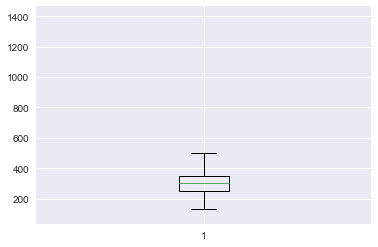

In [53]:
plt.boxplot(data['lunch'].dropna());

Так как на заполняемость сильно влияет цена,то вполне логично сделать признак высокой стоимости ланча

In [54]:
data2=data.fillna(method="backfill")

In [55]:
data2['lunch_big']=data2['lunch']>data2['lunch'].quantile(0.95)

In [56]:
train=data2[:separate]
test=data2[separate:]

In [57]:
X_train,X_valid,y_train,y_valid=train_test_split(train,answer,test_size=0.3,random_state=17)
X_train.shape,X_valid.shape

((219, 280), (94, 280))

In [58]:
lr.fit(X_train,y_train)
xgb.fit(X_train,y_train)
rf.fit(X_train,y_train);

In [59]:
#lr
predict=lr.predict(X_valid)
mean_absolute_error(y_valid,predict)

285.68210379276252

In [60]:
#xgb
predict=xgb.predict(X_valid)
mean_absolute_error(y_valid,predict)

18.733334018829019

In [61]:
#rf
predict=rf.predict(X_valid)
mean_absolute_error(y_valid,predict)

18.082978723404256

Добавление признака высокой стоимости ланча лучушило **randomForest** и **linearRegression**

### 4 try

Посмотрм на признаки которые также напрямую влияюь на заполняемость заведения

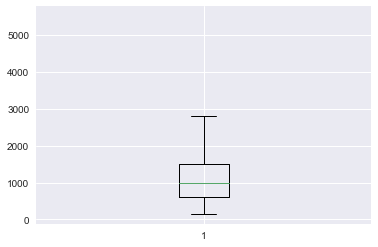

In [65]:
plt.boxplot(data2["price"]);

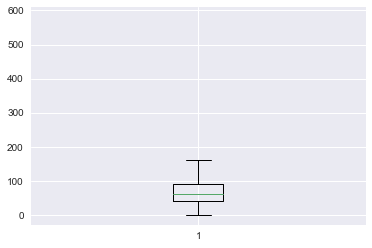

In [66]:
plt.boxplot(data2["n_seats"]);

In [196]:
#По аналогии с ценой на ланч создам признак высокого среднего чека 
data2["price_hight"]=data2["price"]>data2["price"].quantile(0.95)

#Также при слишком большом кол-ве мест сложно обеспечить сильную заполненность(либо это шум в данных)
data2["n_seats_hight"]=data2["n_seats"]>data2["n_seats"].quantile(0.95)

In [184]:
data2.fillna(method="pad",inplace=True)

In [185]:
train=data2[:separate]
test=data2[separate:]

In [186]:
X_train,X_valid,y_train,y_valid=train_test_split(train,answer,test_size=0.3,random_state=17)
X_train.shape,X_valid.shape

((219, 282), (94, 282))

In [187]:
rf.fit(X_train,y_train);
#rf
predict=rf.predict(X_valid)
mean_absolute_error(y_valid,predict)

18.187234042553193

Добавленные признаки только ухудшили модель так что их удалим(можно подобрать квантиль так что score улучшиться но это может привести к переобучению)

In [191]:
data2.drop(["n_seats_hight","price_hight"],axis=1,inplace=True)

### Финальная посылка на Kaggle

In [192]:
train=data2[:separate]
test=data2[separate:]

In [193]:
rf=RandomForestRegressor(random_state=17,n_jobs=-1,criterion="mae");
rf.fit(train,answer);

In [194]:
kaggle(rf,test,drop=False)